In [1]:
from tensorflow.python.platform import build_info as tf_build_info
tf_build_info.build_info
import tensorflow as tf

from platform import python_version
print(python_version())

print(tf.__version__)

2024-04-17 11:16:20.450326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 11:16:20.450366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 11:16:20.451094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 11:16:20.543511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 11:16:22.982794: W tensorflow/c

3.11.9
2.14.0


In [2]:
from tensorflow.keras import layers, optimizers, losses, metrics, activations, regularizers, callbacks
from keras.models import Model
import numpy as np
import pandas as pd
import shap

In [3]:
path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/lead2/"
x_train = np.load(path + 'x_train.npy')
y_train = np.load(path + 'y_train.npy', allow_pickle=True)
x_test  = np.load(path + 'x_test.npy')
y_test  = np.load(path + 'y_test.npy', allow_pickle=True)
print(x_train.shape)

x_train = x_train.reshape(17420, 1, 1000, 1)   # Add another channel
x_test  = x_test.reshape(4381, 1, 1000, 1)

print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)
print('Data loaded')

(17420, 1000)
x_train : (17420, 1, 1000, 1)
y_train : (17420,)
x_test  : (4381, 1, 1000, 1)
y_test  : (4381,)
Data loaded


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer


# Convert multi-label target labels to one-hot encoded matrix
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
print("Classes:", mlb.classes_)

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [5]:
# from tensorflow.keras.models import load_model
# model = load_model('ST-CNN-GAP-5.h5')
from tensorflow.keras.models import load_model
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_lead2new.h5')

2024-04-17 11:16:34.501629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1666 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5


In [6]:
# Load and preprocess an example ECG signal for visualization
import wfdb
import numpy as np

def load_raw_data(filename, sampling_rate, path):
    if sampling_rate == 100:
        data, meta = wfdb.rdsamp(path + filename + "_lr")
    else:
        data, meta = wfdb.rdsamp(path + filename + "_hr")
    return data

# Example usage
# filename_to_load = "21196"  # ST/T change
# filename_to_load = "02696"  # Hypertrophy
# filename_to_load = "03333"  # Normal ECG
# filename_to_load = "00040"  # Normal ECG
# filename_to_load = "03123"  # CD
# filename_to_load = "03196"  # Normal ECG overleaf
# filename_to_load = "03354"  # MI overleaf
# filename_to_load = "03482"  # MI used this
# filename_to_load = "18118"  # HYP use this
# filename_to_load = "03204"  # STTC use this
# filename_to_load = "00279"  # CD use this
filename_to_load = "00262"  # NORM use this, threshold=0.0029999999
sampling_rate = 100
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/02000/"
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/21000/"
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/00000/"
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/00000/"

input_example = load_raw_data(filename_to_load, sampling_rate, path)


In [7]:
input_example.shape

(1000, 12)

In [8]:
import numpy as np

# Extracting values from the second column (Lead 2)
input_example = input_example[:, 1]

In [9]:
input_example = input_example.reshape(1, 1, 1000, 1)   # Add another channel

In [10]:
# Shape of input_example: (1, 1, 1000, 1)
# preprocessed_input = load_image(sys.argv[1])
# x = np.transpose(input_example, (1, 0))                 # transpose matrix
# x = np.expand_dims(x, axis=(0, -1))                # Add another channel on left and right

classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarcation', 'Normal ECG', 'ST/T change']

predictions = model.predict(input_example)


print("Sample belongs to following classes:")
for i in range(5):
    if predictions[0][i] >= 0.5 :
        print(" * " + classes[i])

2024-04-17 11:16:36.229653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-17 11:16:36.421814: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 11:16:36.610281: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step
Sample belongs to following classes:
 * Normal ECG


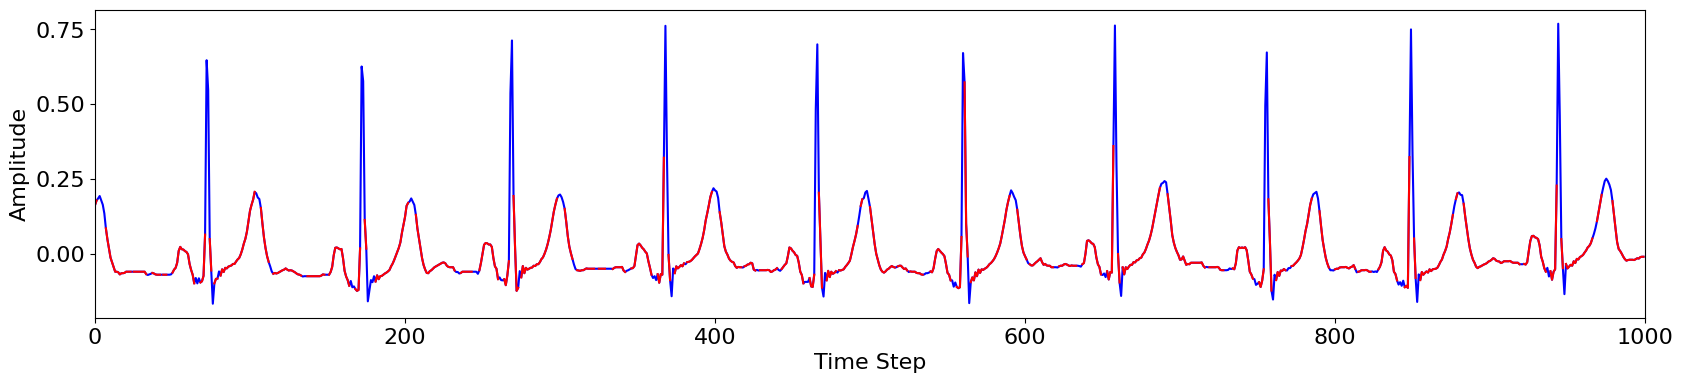

In [50]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the ECG data
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(x, ecg_data[0, 0, :, lead], color='blue')
    
    # Overlay the SHAP values where they are above the threshold
    ax.plot(x, sv_upper, color='red')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Amplitude')
    # ax.set_title(f'SHAP Values Overlay (Sample belongs to: {sample_classes_str})')
    # ax.legend()
        
    # Set the x-axis limits to start from zero
    ax.set_xlim(0, nsteps)
    plt.rc('font', size=20) 
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
# threshold=0.0005
threshold=0.0029999999

plot_shap(ecg_data, sv_data, target_class_idx, lead,threshold, sample_classes=classes)


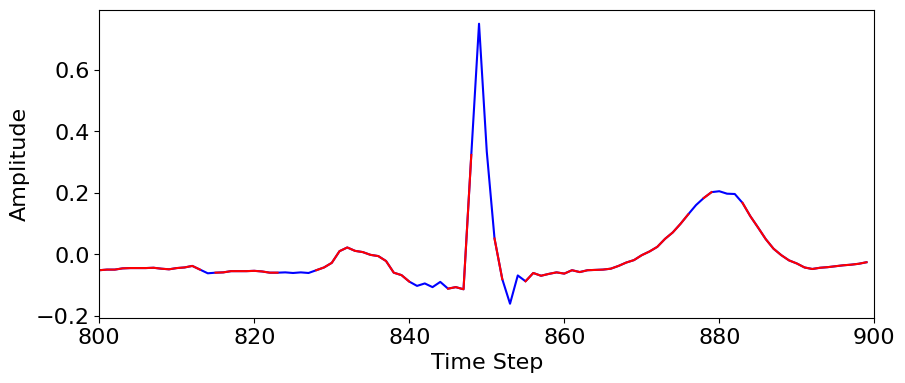

In [49]:
import shap
import numpy as np
import matplotlib.pyplot as plt


# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap2(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes, start_index, end_index):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the ECG data
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x[start_index:end_index], ecg_data[0, 0, start_index:end_index, lead], color='blue')
    
    # Overlay the SHAP values where they are above the threshold
    ax.plot(x[start_index:end_index], sv_upper[start_index:end_index], color='red')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Amplitude')
    # ax.set_title(f'SHAP Values Overlay (Sample belongs to: {sample_classes_str})')
    # ax.legend()
    
    # Set the x-axis limits to start from zero
    ax.set_xlim(start_index, end_index)
    plt.rc('font', size=16)
    
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
# threshold=0.0005
threshold=0.0029999999

plot_shap2(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes=classes, start_index=800, end_index=900)
# plot_shap2(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes=classes, start_index=550, end_index=600)


### DIvide to segment and test

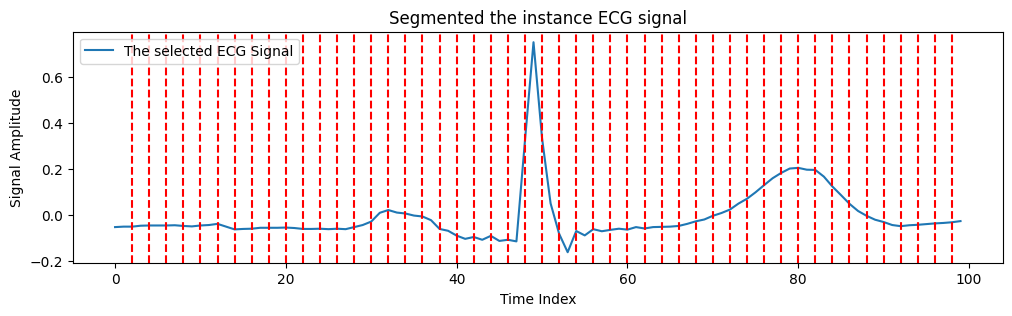

In [11]:
from visualization import plot_segmented_ecg
from lime_explanation import segment_ecg_signal
import numpy as np
import matplotlib.pyplot as plt
input_example2 = np.reshape(input_example, (1000, 1))
instance_ecg = input_example2[800:900]
# Segmentation using the fixed number of slices
num_slices = 50 
slice_width = segment_ecg_signal(instance_ecg, num_slices)

plt.rc('font', size=10)
# plot the segmented ECG signal
plot_segmented_ecg(instance_ecg, slice_width)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


segment_length: 2
segment_shap_values: [-3.84366067e-05  7.26890983e-03  9.69965570e-03  7.21365865e-03
 -4.21514240e-04  6.29589136e-04  1.98347028e-03  1.33972627e-03
  8.73043435e-04 -3.17254011e-03 -4.01748670e-03  3.78155702e-04
  3.99490492e-03  1.32860360e-03 -5.57656982e-04  2.49589721e-05
  2.09905813e-03  6.19056821e-03  5.02398377e-03 -1.74875068e-03
 -5.47626894e-03  3.14865797e-03 -1.90423871e-03  5.61790587e-03
  8.02217983e-03 -1.13922695e-03  1.55136036e-03 -1.02924845e-04
  7.64123513e-04  1.96709094e-04  6.60757767e-04 -3.49874166e-03
  1.55293886e-02  2.74256412e-02 -7.47810723e-03 -9.21838277e-04
  2.04213411e-02  5.37400600e-04  2.68631405e-03 -5.27612050e-04
  3.29151982e-03  3.47250898e-05  2.50662584e-03  6.50383532e-04
  8.17425258e-04  1.73650775e-03  2.73419009e-05  2.03033589e-04
  1.46696437e-03  9.16397548e-04]
top_segments: [24  2 32 36 33]


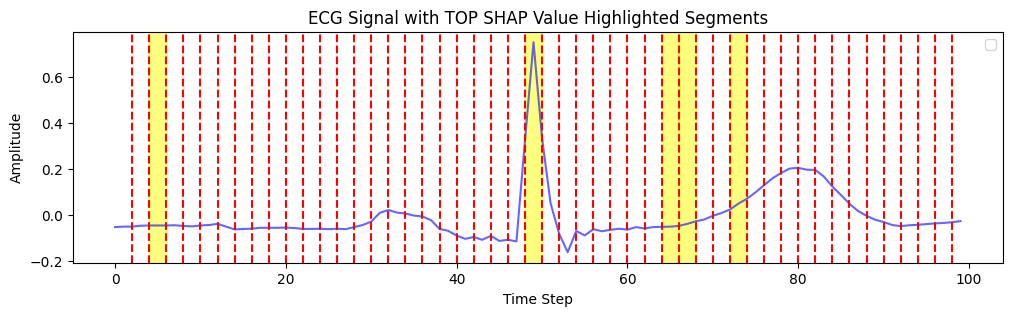

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute SHAP values for each segment
def compute_segment_shap_values(ecg_data, target_class_idx, sv_data, num_slices, lead):
    segment_shap_values = np.zeros(num_slices)
    # num_samples, num_features = sv_data.shape
    segment_length = len(ecg_data) // num_slices
    print(f"segment_length: {segment_length}")


    for i in range(num_slices):
        segment_start = i * segment_length
        segment_end = (i + 1) * segment_length
        # segment_shap_values[i] = np.mean(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
        segment_shap_values[i] = np.max(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
    
    return segment_shap_values


# Define a function to plot the ECG signal with highlighted segments based on top SHAP values
def plot_shap_highlighted_segments(ecg_data, sv_data, num_slices, top_segments):
    ecg_data = ecg_data.squeeze()  # Remove singleton dimensions

    plt.figure(figsize=(12, 3))
    plt.rc('font', size=10)

    # plt.plot(ecg_data, color='blue', label='Original ECG Signal', alpha=0.6)
    plt.plot(ecg_data, color='blue', alpha=0.6)

    # Plot vertical lines to separate segments
    for i in range(1, num_slices):
        plt.axvline(x=i * (len(ecg_data) // num_slices), color='r', linestyle='--')

    # Highlight top influential segments
    for segment in top_segments:
        start_idx = segment * (len(ecg_data) // num_slices)
        end_idx = start_idx + (len(ecg_data) // num_slices)
        plt.axvspan(start_idx, end_idx, color='yellow', alpha=0.5)

    plt.title('ECG Signal with TOP SHAP Value Highlighted Segments')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage:import numpy as np
import matplotlib.pyplot as plt
input_example2 = np.reshape(input_example, (1000, 1))
instance_ecg = input_example2[800:900]
lead = 0
num_slices = 50  # Number of slices
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
segment_shap_values = compute_segment_shap_values(instance_ecg, target_class_idx, shap_values, num_slices, lead)
print(f"segment_shap_values: {segment_shap_values}")
# Get indices of top segments based on SHAP values
top_segments = np.argsort(segment_shap_values)[-5:]  # Change 5 to the number of top segments you want to visualize
print(f"top_segments: {top_segments}")

# Plot the ECG signal with highlighted segments
plot_shap_highlighted_segments(instance_ecg, shap_values, num_slices, top_segments)


segment_shap_values: [-2.25891927e-04  6.46109390e-03  1.04080131e-02  4.37852094e-03
 -1.27445936e-03  5.63788195e-04  2.16274522e-03  3.09971263e-04
  3.72461720e-04 -3.73479119e-03 -4.42381529e-03 -1.68785310e-03
  3.18631588e-03 -2.29476223e-04 -6.89442677e-04 -5.56808372e-05
  1.33805566e-03  6.82755397e-03  2.79483656e-03 -3.96131584e-03
 -8.81486223e-03  1.85429180e-03 -3.32482229e-03  3.18806742e-03
  6.36853976e-03 -1.15079439e-03  1.11996275e-03 -2.84340311e-04
  8.31706973e-04  9.80723853e-05  3.26477111e-04 -5.60442870e-03
  7.15649640e-03  1.85981593e-02 -1.61690810e-02 -4.16803313e-03
  1.56269786e-02  7.97459506e-05  1.74234371e-03 -1.23259236e-03
  1.61897254e-03 -8.45455681e-04 -4.58932598e-04  8.55763385e-04
  7.59972565e-04  1.32303141e-03  1.35156442e-05  1.13267599e-04
  1.49634515e-03  9.65273415e-04]
top_segments: [17 32  2 36 33]


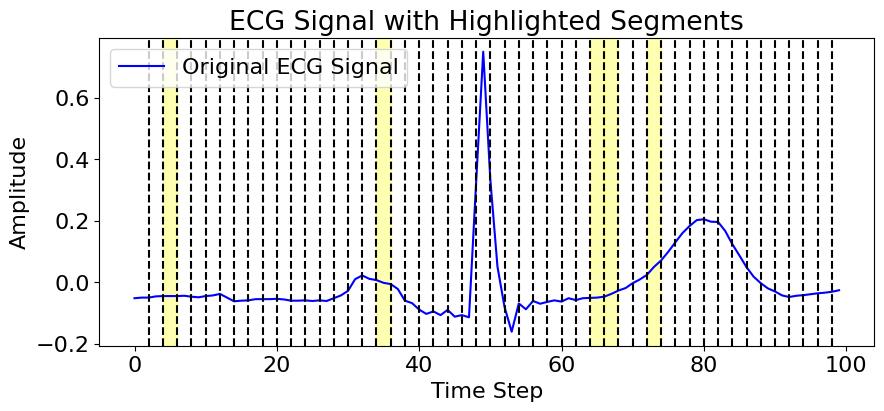

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import shap

    # lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]
    # # Create masks based on the threshold
    # sv_upper_mask = lead_shap_values >= threshold
    # sv_lower_mask = lead_shap_values < threshold

# Define a function to compute SHAP values for each segment
def compute_segment_shap_values(ecg_data, target_class_idx, sv_data, num_slices, lead):
    segment_shap_values = np.zeros(num_slices)
    # num_samples, num_features = sv_data.shape
    segment_length = len(ecg_data) // num_slices

    for i in range(num_slices):
        segment_start = i * segment_length
        segment_end = (i + 1) * segment_length
        segment_shap_values[i] = np.mean(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
    
    return segment_shap_values


# Define a function to plot the ECG signal with highlighted segments based on top SHAP values
def plot_shap_highlighted_segments(ecg_data, sv_data, num_slices, top_segments):
    ecg_data = ecg_data.squeeze()  # Remove singleton dimensions

    plt.figure(figsize=(10, 4))
    plt.plot(ecg_data, color='blue', label='Original ECG Signal', color='blue', alpha=0.6)

    # Plot vertical lines to separate segments
    for i in range(1, num_slices):
        plt.axvline(x=i * (len(ecg_data) // num_slices), color='r', linestyle='--')

    # Highlight top influential segments
    for segment in top_segments:
        start_idx = segment * (len(ecg_data) // num_slices)
        end_idx = start_idx + (len(ecg_data) // num_slices)
        plt.axvspan(start_idx, end_idx, color='yellow', alpha=0.5)

    plt.title('ECG Signal with Highlighted Segments')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have computed SHAP values for the input_example and identified top segments
ecg_data = instance_ecg
shap_values = shap_values  # Assuming you have computed SHAP values
lead = 0
num_slices = 50  # Number of slices
segment_shap_values = compute_segment_shap_values(ecg_data, target_class_idx, shap_values, num_slices, lead)
print(f"segment_shap_values: {segment_shap_values}")
# Get indices of top segments based on SHAP values
top_segments = np.argsort(segment_shap_values)[-5:]  # Change 5 to the number of top segments you want to visualize
print(f"top_segments: {top_segments}")

# Plot the ECG signal with highlighted segments
plot_shap_highlighted_segments(ecg_data, shap_values, num_slices, top_segments)


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0] [lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the SHAP values
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(x, sv_upper, label='SHAP Values (Upper)', color='blue')
    ax.plot(x, sv_lower, label='SHAP Values (Lower)', color='red')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.set_title(f' (Sample belongs to: {sample_classes_str})')
    ax.legend()
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
# threshold=0.001
threshold=0.003

plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes=classes)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0] [lead]
    
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the SHAP values
    fig, ax = plt.subplots(figsize=(20,4))
    
    # Plot SHAP values higher than threshold in red, others in blue
    ax.plot(x, sv_upper, label='SHAP Values (Upper)', color='blue')
    ax.plot(x, sv_lower, label='SHAP Values (Lower)', color='red')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.set_title(f' (Sample belongs to: {sample_classes_str})')
    ax.legend()
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
threshold = 0.001

plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes=classes)


In [ ]:

# shap_values is a list where each element corresponds to Shapley values for a class
# In your case, it should be a list of length 5 (assuming 5 classes)
print("Number of classes:", len(shap_values))

# Print the shape of Shapley values for each class
for i, class_values in enumerate(shap_values):
    print(f"Class {i + 1} - Shape of Shapley values:", class_values.shape)

In [12]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


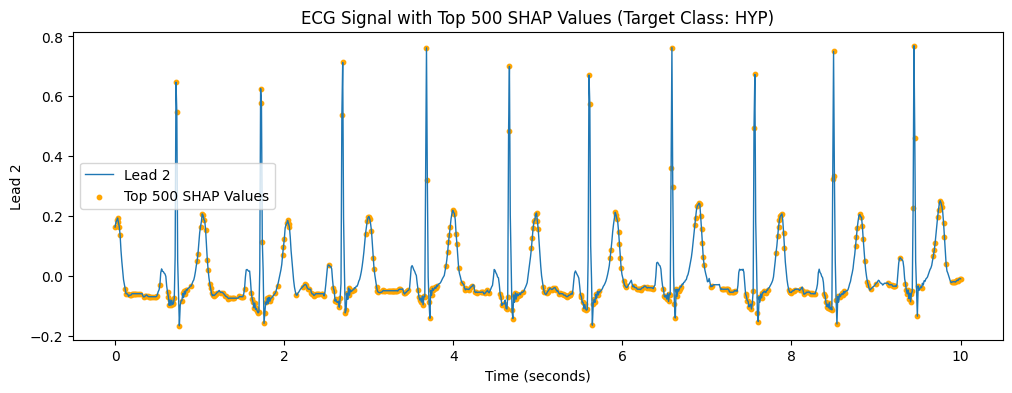

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-500:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)


# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 2')
top_shap_values = target_shap_values[top_indices]

# Scale the SHAP values to the range of ECG data for better visualization
scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)

# Highlight corresponding ECG signal points with orange color
ax.scatter(time[top_indices[1]], lead_data[top_indices[1]], color='orange', s=10, label='Top 500 SHAP Values')

ax.set_ylabel('Lead 2')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: HYP)')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-500:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)


# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 2')
top_shap_values = target_shap_values[top_indices]

# Scale the SHAP values to the range of ECG data for better visualization
scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)

# Highlight corresponding ECG signal points with orange color
ax.scatter(time[top_indices[1]], lead_data[top_indices[1]], color='orange', s=10, label='Top 500 SHAP Values')

ax.set_ylabel('Lead 2')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: MI)')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-100:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)


# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 2')
top_shap_values = target_shap_values[top_indices]

# Scale the SHAP values to the range of ECG data for better visualization
scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)

# Highlight corresponding ECG signal points with orange color
ax.scatter(time[top_indices[1]], lead_data[top_indices[1]], color='orange', s=10, label='Top 500 SHAP Values')

ax.set_ylabel('Lead 2')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: Norm)')
plt.show()


In [ ]:
shap_values = np.load('shap_values.npy')
shap_values.shape

# Old output: (5, 5, 12, 1000, 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 12, 1000, 1]

ecg_data = x
batch_size, num_leads, signal_length, _ = ecg_data.shape

# Sample SHAP values with dimensions [batch size, 5, 12, 1000, 1]

shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 1  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[0, target_class_idx, :, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.unravel_index(np.argsort(np.abs(target_shap_values).ravel())[-500:], target_shap_values.shape)

# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, signal_length / sampling_rate, signal_length)

# Create subplots for each lead
fig, axes = plt.subplots(num_leads, 1, figsize=(10, 12), sharex=True)

# Plot each lead with overlay of SHAP values for the target class
for lead_idx in range(num_leads):
    lead_data = ecg_data[0, lead_idx, :, 0]
    axes[lead_idx].plot(time, lead_data, lw=1, label=f'Lead {lead_idx + 1}')
    top_shap_indices = np.where(top_indices[0] == lead_idx)[0]
    top_shap_values = target_shap_values[lead_idx, top_indices[1][top_shap_indices]]

    # Scale the SHAP values to the range of ECG data for better visualization
    scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)
    
    # Highlight corresponding ECG signal points with orange color
    axes[lead_idx].scatter(time[top_indices[1][top_shap_indices]], lead_data[top_indices[1][top_shap_indices]], color='orange', s=10)
    axes[lead_idx].set_ylabel(f'Lead {lead_idx + 1}')

axes[num_leads - 1].set_xlabel('Time (seconds)')
plt.suptitle('ECG Signals with Top 500 SHAP Values (Target Class)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

